___

<a href='http://www.pieriandata.com'>www.pieriandata.com</a>
___
<center><em>Copyright by Pierian Data Inc.</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# Q Learning Exercise 

**We'll be reviewing and testing your skills with Q-Learning on a continuous space! Please feel free to reference the lecture notebooks you are definitely not expected to be able to fill out all this code from memory, just the ability to understand the core concepts and apply it to a different situation.**

--------------------

## Complete the tasks in bold below.

In this exercise we take a look at the MountainCar-v0 (https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) game again. That is the game from our original discussion of OpenAi gym (now [Gymnasium](https://gymnasium.farama.org/)) environments for which we created an agent manually.
Remember, that the goal is to reach the top of the mountain within some time limit

-----

**TASK: Import any relevant libraries you think you might need.** <br />


In [ ]:
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install ipympl > /dev/null 2>&1

!pip install swig==4.1.1
!pip install Box2D==2.3.2
!pip install box2d-kengz==2.3.3
!pip install pygame==2.2.0
!pip install ale_py==0.8.1
!pip install pyglet==1.5.11

!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install --upgrade AutoROM
!AutoROM --accept-license
!pip install gymnasium[atari,accept-rom-license]==0.28.1

!wget http://www.atarimania.com/roms/Roms.rar
!unrar x -o+ /content/Roms.rar >/dev/nul
!python -m atari_py.import_roms /content/ROMS >/dev/nul

!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install matplotlib > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [70]:
import time
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

from IPython.display import clear_output

%matplotlib inline

In [71]:
def show_environment(array):
    plt.axis("off")
    plt.imshow(array)
    plt.show()

**TASK: Create the gym mountain car environment** <br />


In [72]:
env_name = "MountainCar-v0"
env = gym.make(env_name, render_mode="rgb_array")

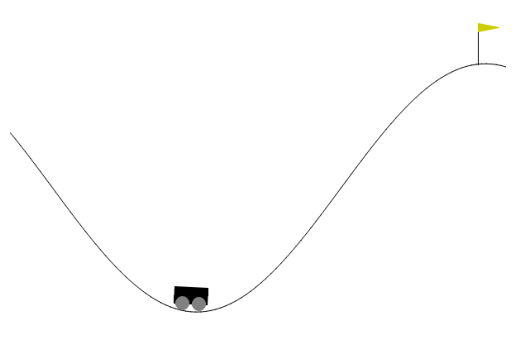

In [73]:
state, info = env.reset()
for step in range(50):
    environment = env.render()
    show_environment(environment)
    action = env.action_space.sample()
    state, reward, term, trunc, info = env.step(action)
    time.sleep(0.02)
    if term or trunc:
        stete, info = env.reset()
        break
    clear_output(wait=True)
env.close()

## Observation Space

The observation is a ndarray with shape (2,) where the elements correspond to the following:

|Num|Observation|Min|Max|Unit
|--|--|--|--|--|
|0|position of the car along the x-axis|-1.2|0.6|position (m)|
|1|velocity of the car|-0.07|0.07|position (m)|

## Action Space

The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1] and multiplied by a power of 0.0015.

**TASK: Write a function to create a numpy array holding the bins for the observations of the car (position and velocity).** <br />
Feel free to explore different bins per observation spacings.
The function should take one argument which acts as the bins per observation <br />
Hint: You can find the observations here: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py
<br /> Hint: You will probably need around 25 bins for good results, but feel free to use less to reduce training time. <br />


In [74]:
def create_bins(num_bins_per_observation: int):
    bins_position = np.linspace(-1.2, 0.6, num_bins_per_observation)
    bins_velocity = np.linspace(-0.07, 0.07, num_bins_per_observation)
    bins = np.array([bins_position, bins_velocity])
    return bins

**TASK: Here you should write the code which creates the bins and defines the NUM_BINS attribute**

In [75]:
NUM_BINS = 25
BINS = create_bins(NUM_BINS)
print(f"Position bins: {BINS[0]}")
print(f"Velocity bins: {BINS[1]}")

Position bins: [-1.2   -1.125 -1.05  -0.975 -0.9   -0.825 -0.75  -0.675 -0.6   -0.525
 -0.45  -0.375 -0.3   -0.225 -0.15  -0.075  0.     0.075  0.15   0.225
  0.3    0.375  0.45   0.525  0.6  ]
Velocity bins: [-0.07       -0.06416667 -0.05833333 -0.0525     -0.04666667 -0.04083333
 -0.035      -0.02916667 -0.02333333 -0.0175     -0.01166667 -0.00583333
  0.          0.00583333  0.01166667  0.0175      0.02333333  0.02916667
  0.035       0.04083333  0.04666667  0.0525      0.05833333  0.06416667
  0.07      ]


**TASK: Create a function that will take in observations from the environment and the bins array and return the discretized version of the observation.**

Now we need the code to discretize the observations. We can use the same code as used in the last notebook

In [76]:
def discretize_observation(observations, bins):
    binned_observations = []
    for observation, bin in zip(observations, bins):
        binned_observations.append(np.digitize(observation, bin))
    return tuple(np.array(binned_observations)) # Important for later indexing

**Let's check to make sure your previous two function calls work with a quick task! Otherwise it may be hard to debug later on.**

**TASK: Confirm that your *create_bins()* function works with *discretize_observation() by running the following cell***

In [77]:
test_bins = create_bins(5)
np.testing.assert_almost_equal(test_bins[0], [-1.2 , -0.75, -0.3 ,  0.15,  0.6])
np.testing.assert_almost_equal(test_bins[1], [-0.07 , -0.035,  0.   ,  0.035,  0.07 ])

test_observation = np.array([-0.9, 0.03])
discretized_test_bins = discretize_observation(test_observation, test_bins)
assert discretized_test_bins == (1, 3)

In [78]:
discretized_observation = discretize_observation(state, BINS)
discretized_observation

(9, 13)

In [80]:
state

array([-0.54158837,  0.0030485 ], dtype=float32)

**TASK: Create the Q-Table** <br />
Remember the shape that the Q-Table needs to have.

In [82]:
q_table_shape = (NUM_BINS, NUM_BINS, env.action_space.n)
q_table = np.zeros(q_table_shape)
q_table.shape

(25, 25, 3)

**TASK: Fill out the Epislon Greedy Action Selection function:**

In [96]:
def epsilon_greedy_action_selection(env, epsilon, q_table, discrete_state):
    random_action = np.random.random()
    if random_action < epsilon:  # Exploration
        action = env.action_space.sample()
    else:  # Exploitation
        action = np.argmax(q_table[discrete_state])
    return action

**TASK: Fill out the function to compute the next Q value.**

In [97]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    return old_q_value + ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

**TASK: Create a function to reduce epsilon, feel free to choose any reduction method you want. We'll use a reduction with BURN_IN and EPSILON_END limits in the solution. We'll also show a way to reduce epsilon based on the number of epochs. Feel free to experiment here.**

In [98]:
def reduce_epsilon(epsilon, epoch):
    if BURN_IN < epoch <= EPSILON_END:
        epsilon -= EPSILON_REDUCE
    return epsilon

**TASK: Define your hyperparameters. Note, we'll show our solution hyperparameters here, but depending on your *reduce_epsilon* function, your epsilon hyperparameters may be different.**

Here are the solution initial hyperparameters, your will probably be different!

In [99]:
# Feel free to change!

EPOCHS = 30000
BURN_IN = 100
epsilon = 1

EPSILON_END = 10000
EPSILON_REDUCE = 0.0001 

ALPHA = 0.8
GAMMA = 0.9

**TASK: Create the training loop for the reinforcement learning agent and run the loop. We've gone ahead and created the basic structure of the loopwith some comments. We also pre-filled the visualization portion.** <br />
Note: Use the lecture notebook as a guide and reference

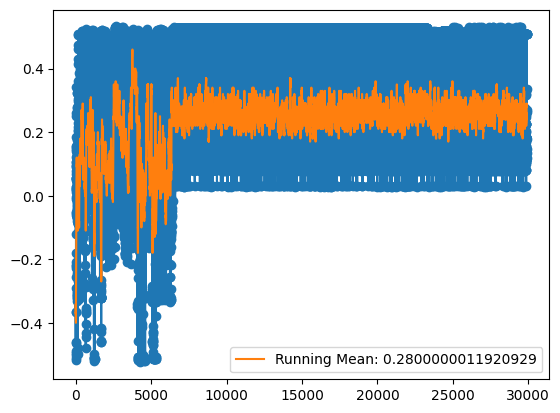

In [105]:
####### VISUALIZATION CODE FOR YOU. TOTALLY OPTIONAL. ##########################
########## FEEL FREE TO REMOVE OR ADD YOUR OWN VISUAL CODE. #################

log_interval = 100  # How often do we update the plot? (Just for performance reasons)
### Here we set up the routine for the live plotting of the achieved points ######
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()

max_position_log = []  # to store all achieved points
mean_positions_log = []  # to store a running mean of the last 30 results
epochs = []  # store the epoch for plotting

#############################################################################
################################## TRAINING TASKS ##########################
###########################################################################
for epoch in range(EPOCHS):
    ################################# TODO ######################################
    
    # Get initial observation and discretize them. Set done to False
    observation, info = env.reset()
    discretized_observation = discretize_observation(observation, BINS)
    done = False
    #############################
    # These lines are for plotting.
    max_position = -np.inf  
    epochs.append(epoch)
    #############################
    
    # As long as current run is alive (i.e not done) perform the following steps:
    while not done:  # Perform current run as long as done is False (as long as there is still time to reach the top)

        # Select action according to epsilon-greedy strategy
        action = epsilon_greedy_action_selection(env, epsilon, q_table, discretized_observation)
        # Perform selected action and get next state. Do not forget to discretize it
        next_observation, reward, term, trunc, info = env.step(action)
        position, velocity = next_observation
        next_discretized_observation = discretize_observation(next_observation, BINS)
        next_optimal_q_value = np.max(q_table[next_discretized_observation])
        # Get old Q-value from Q-Table and get next optimal Q-Value
        old_q_value = q_table[discretized_observation + (action,)]
        # Compute next Q-Value and insert it into the table
        next_q_value = compute_next_q_value(old_q_value, reward, next_optimal_q_value)
        q_table[discretized_observation + (action,)] = next_q_value
        # Update the old state with the new one
        discretized_observation = next_discretized_observation
        ##############################
        ##  Only for plotting the results - store the highest point the car is able to reach
        if position > max_position:
            max_position = position
        done = term or trunc

    # TASK TO DO: Reduce epsilon
    epsilon = reduce_epsilon(epsilon, epoch)
    ##############################################################################

    max_position_log.append(max_position)  # log the highest position the car was able to reach
    running_mean = round(np.mean(max_position_log[-30:]), 2)  # Compute running mean of position over the last 30 epochs
    mean_positions_log.append(running_mean)  # and log it
    
    ################ Plot the points and running mean ##################
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs, max_position_log)
        ax.plot(epochs, max_position_log)
        ax.plot(epochs, mean_positions_log, label=f"Running Mean: {running_mean}")
        plt.legend()
        fig.canvas.draw()
  ######################################################################

env.close()

**TASK: Use your Q-Table to test your agent and render its performance.**

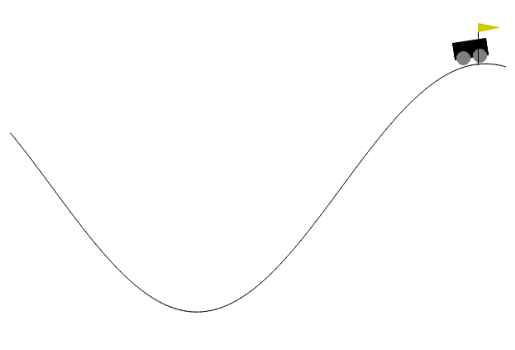

In [106]:
observation, info = env.reset()
for step in range(1000):
    environment = env.render()
    show_environment(environment)
    discretized_observation = discretize_observation(observation, BINS)
    action = np.argmax(q_table[discretized_observation])
    observation, reward, term, trunc, info = env.step(action)
    clear_output(wait=True)
    if term or trunc:
        break
env.close()

In [107]:
np.save("25bin_qtable_mountaincar.npy", q_table)

**OPTIONAL: Play with our Q-Table with 40 bins per observation.**

In [42]:
our_q_table = np.load('40bin_qtable_mountaincar.npy')

In [44]:
our_q_table.shape

(40, 40, 3)

**Great job! Note how you could train for many more epochs/episodes or edit hyperparameters, the more complex the environment, the more choices you have to experiment with!**